# Task 2: PPE

In this task, you are going to create a model to identify if a person is wearing a **face mask**
and a **safety helmet**

Provided files:
- Image dataset of 591 pics
- .xml annotation file

In [152]:
### importing libraries:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [58]:
### uploading and reading of the provided .xml file

xml_path = "C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\annotations.xml"
annotations = ElementTree.parse(xml_path)
root = annotations.getroot()

In [138]:
### inspecting the provided dataset and annotations:

print("This image's id is ", root[95].attrib["id"])
for x in root[95]:
    print(x.attrib)

This image's id is  121
{'label': 'head', 'occluded': '0', 'xtl': '22.26', 'ytl': '0.00', 'xbr': '155.82', 'ybr': '120.84'}


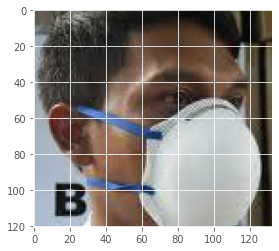

In [142]:
### cropping out face via obtained coordinates:

img = cv2.imread("C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\images\\121.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

xtl = 23; ytl = 0; 
xbr = 156; ybr = 121;
head = img[ytl:ybr, xtl:xbr]
plt.imshow(head)

---

## Preparing Dataset:

Thus, we find out how the structure of annotation and image dataset is set. Next, we should prepare our dataset for training.

1) We should prepare data and label lists containing image and its corresponding label  
2) Standartize all the images into one common resolution which was chosen (after several testings) to be 32x32   
3) Checking the dictionary of errors containing skipped images. This is necessary to regulate the threshold of our filter.  

In [143]:

data = []
label = []

### this variable stands for shape of standartized images:
dim = (32, 32)

### this variable is to check out how many images and objects could not pass our filter
### (this was needed to fix/adjust threshold of the filter)
dict_to_track_errors = {}; small_image=0; no_human_face=0;

for image in root[2:]:
    image_id = image.attrib["id"]
    path = "C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\images\\{}.jpg".format(image_id)
    img = load_img(path)
    img = img_to_array(img)
    try:
        for objects in image:
            
            ### finding out the face box for each person in the image:
            if (objects.attrib["label"] == "head"):
                xtl = int(float(objects.attrib["xtl"]))
                ytl = int(float(objects.attrib["ytl"]))
                xbr = int(float(objects.attrib["xbr"]))
                ybr = int(float(objects.attrib["ybr"]))
                
                ### cropping out the face:
                head_img = img[ytl:ybr, xtl:xbr]
                
                ### a filter to remove very small images which will be negatively effecting the model:
                if head_img.shape[0] > 8 and head_img.shape[1] > 8:
                    
                    ### resizing all images to standartize their resolution for model:
                    resized = cv2.resize(head_img, dim, interpolation = cv2.INTER_AREA)
                    #preprocessed = preprocess_input(resized)
                    data.append(resized)
                    
                    
                    
    ### we equal label to 1 only in case person is wearing both safety helmet and mask
    ### all other cases are considered as label=0
                    for conditions in objects:
                        if (conditions.attrib["name"] == "has_safety_helmet"): safety_helmet = conditions.text
                        if (conditions.attrib["name"] == "mask"): mask = conditions.text
                    mark = [1 if (safety_helmet == 'yes' and mask == 'yes') else 0]
                    label.append(mark[0])
                else: 
                    small_image += 1
                
            else:
                no_human_face += 1

    except Exception as err:
        print(err)

dict_to_track_errors["too small_image count"] = small_image
dict_to_track_errors["no face images count"] = no_human_face


In [144]:
### from below results we could observe that 344 face images were excluded from training dataset due to resolution.

### the final dataset with 1448 images in considered low in quantity for model traning, therefore, we should try 
### out different variations of image resolution, and come up with the best approach:

print(len(data))
print(len(label))
dict_to_track_errors

1448
1448


{'too small_image count': 344, 'no face images count': 2674}

In [145]:
### we see that "other cases" are three times more than cases with mask and safety helmet wearing people.
### therefore, we will probably need "stratify" argument in splitting the data

print("There are ", sum(label), " cases with mask and safety helmet")
print("There are ", len(label) - sum(label), " other cases")

There are  339  cases with mask and safety helmet
There are  1109  other cases


In [146]:
### converting them into numpy arrays for training:

datas = np.array(data, dtype="float32")
labels = np.array(label)

In [147]:
### split into train test sets:

(trainX, testX, trainY, testY) = train_test_split(datas, labels, test_size=0.30, stratify=labels, random_state=42)

---

## Training a model:

In [87]:
### As our image resolutions are small and dataset is also small, we will probably try out a simple model for training.

### 

### MaxPooling2D was used for this model because mask and helmets are usually bright in color while the backgrounds are darker.
### Therefore, I believe in our case MaxPooling will work out good. 

In [148]:
### the model layers:

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [149]:
### ImageDataGenerator is commonly used in classification models to change shape, resolution, position of an image.
### As we are having scarcity of images for training, this approach will probably justify its usage.

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [150]:
### hyperparameter values selected by us:

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [153]:
### for this classification problem we are going to use standard "accuracy" metrics

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [154]:
### training a model:

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
31/31 [==============================] - 1s 42ms/step - loss: 7.9286 - accuracy: 0.5655 - val_loss: 2.4894 - val_accuracy: 0.7402
Epoch 2/20
31/31 [==============================] - 1s 35ms/step - loss: 1.5985 - accuracy: 0.6463 - val_loss: 1.4183 - val_accuracy: 0.6874
Epoch 3/20
31/31 [==============================] - 1s 37ms/step - loss: 1.2744 - accuracy: 0.6626 - val_loss: 1.1413 - val_accuracy: 0.6828
Epoch 4/20
31/31 [==============================] - 1s 35ms/step - loss: 1.0209 - accuracy: 0.6667 - val_loss: 1.0203 - val_accuracy: 0.6322
Epoch 5/20
31/31 [==============================] - 1s 36ms/step - loss: 0.9639 - accuracy: 0.6769 - val_loss: 0.9057 - val_accuracy: 0.7264
Epoch 6/20
31/31 [==============================] - 1s 36ms/step - loss: 0.9095 - accuracy: 0.6809 - val_loss: 0.8174 - val_accuracy: 0.6621
Epoch 7/20
31/31 [==============================] - 1s 36ms/step - loss: 0.7424 - accuracy: 0.7003 - val_loss: 0.7574 - val_accuracy: 0.7034
Epoch 8/20
31

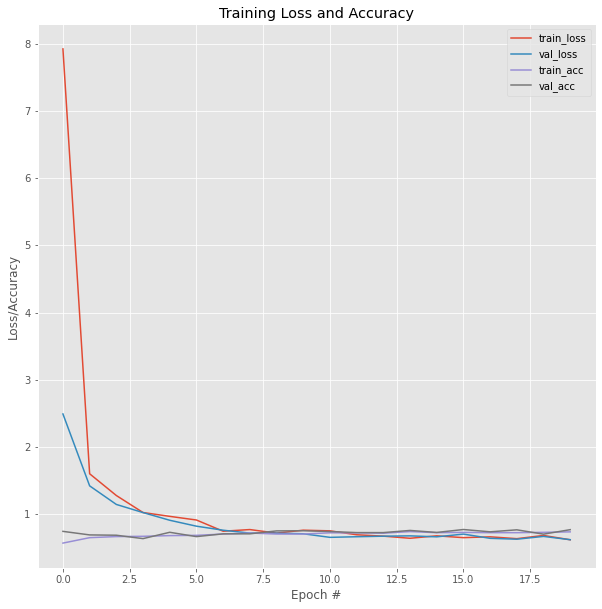

In [156]:
### plotting the accuracy and loss curves for both train and test sets:

N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize = (10, 10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [157]:
### From a curve, we could observe slight convergance of validation accuracy. This means model was learning a little bit.
### In average 74% accuracy on validation set was obtained during training.

---

## Save a model:

In [158]:
### as a final step, we have to save our model

model.save("mask_detector.model", save_format="h5")